# Estimate specific surface using grain size distribution data

Loads grains size distributions from a .csv file and calculate grain size statistics and specific surface following eq. 2 in Luijendijk and Gleeson (2015, Geofluids 15, or Crustal permeability book chapter 2016) ([link](https://onlinelibrary.wiley.com/doi/full/10.1111/gfl.12115)).

and example csv file that contains grain size data from a borehole in the southern netherlands is located in the subdirectory data [here](data/porperm_data_well_AST02.csv).

the column headers should includde the grain size bins and should be formatted like ``2-4_micron``. The first and last columns to be included in the grain size calculation should be specified in the notebook below.

Note that to use the separate notebook to calculate permeability of sediment mixtures one should calculate the specific surface of the granular fraction only and exclude the clay fraction. This is usually done by excluding grains that are smaller than 2 micron, although this may not be 100% correct in all cases.

## Import Python modules


In [1]:
import math
import os
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as pl

## Set up a function to calculate specific surface

In [2]:
def calculate_specific_surface_discrete(grain_size, freq, rho_s):
    
    """
    calculate specific surface
    eq. ... in 
    """
    
    ss = 6.0 / rho_s * (freq / grain_size).sum()
    
    return ss

## Define density of sediment matrix:

In [3]:
# file containing grain size distribution data
# uncomment (remove the # sign) one of the filenames below:
filename = 'data/porperm_data_well_AST02.csv'

# density of the sediment matrix (kg / m3)
rho_s = 2650.0

## load grain size data

In [4]:
df = pd.read_csv(filename)

## Specify first and last columns with grain size data:

In [5]:
first_gs_col = '2-4_micron'
last_gs_col = '1680-2000_micron'

## find columns with grain size data

In [6]:
cols = df.columns.tolist()
grain_size_ind1 = cols.index(first_gs_col)
grain_size_ind2 = cols.index(last_gs_col)+1

## Go through columns and get grain size data:

In [7]:
gs_bin_min = [col.split('-')[0] for col in cols[grain_size_ind1:grain_size_ind2]]
gs_bin_max = [col.split('-')[1].split('_')[0] for col in cols[grain_size_ind1:grain_size_ind2]]

gs_bin_min = np.array(gs_bin_min).astype(float)
gs_bin_max = np.array(gs_bin_max).astype(float)

gs_bin_mean = (np.array(gs_bin_min).astype(float) + np.array(gs_bin_max).astype(float)) / 2.0

## Calculate specific surface:

In [8]:
df['specific_surface_granular_fraction'] = 0.0

# calculate specific surface from grain size distribution
for row in df.iterrows():
    
    gs = row[1][grain_size_ind1:grain_size_ind2].values.astype(float) / 100.0
    df.loc[row[0], 'specific_surface_granular_fraction'] = calculate_specific_surface_discrete(gs_bin_mean * 1.0e-6, gs, rho_s)

## Calculate statistics grain size distributions

Not used for calculating specific surface, but may be useful for later analysis

FOr each sample 1000 monte carlo realizations are gneerated to reflect the unknown distribution of grainsizes within bins


In [9]:
for row in df.iterrows():

    # create synthetic grain size sample
    realizations = []
    freq = row[1][grain_size_ind1:grain_size_ind2].values.astype(float)[:-1]
    if True not in np.isnan(freq):
        
        # generate realizations:
        for gs1, gs2, f in zip(gs_bin_min * 1e-6, gs_bin_max * 1e-6, freq * 1000.0):
            realizations += [np.random.random() * (gs2 - gs1) + gs1] * int(f)
        realizations = np.array(realizations)
        
        # get ln normal stats grain size distribution
        df.loc[row[0], 'ln_grainsize_mean'] = np.mean(np.log(realizations))
        df.loc[row[0], 'ln_grainsize_std'] = np.std(np.log(realizations))
        
        # get log normal stats grain size distribution
        df.loc[row[0], 'log10_grainsize_mean'] = np.mean(np.log10(realizations))
        df.loc[row[0], 'log10_grainsize_std'] = np.std(np.log(realizations))
        
        # and median grain size
        df.loc[row[0], 'median_grainsize'] = np.median(realizations)

## Save modified csv file with calculated grain sizes:

In [10]:
print('modified .csv file:')
df.head()

modified .csv file:


,well,sample_number,depth,0-2_micron,2-4_micron,4-8_micron,8-16_micron,16-25_micron,25-35_micron,35-50_micron,...,kaolinite_fraction,illite_fraction,smectite_fraction,note,specific_surface_granular_fraction,ln_grainsize_mean,ln_grainsize_std,log10_grainsize_mean,log10_grainsize_std,median_grainsize
0,AST-02,79,1517.25,16.1,4.8,6.6,7.1,5.0,2.4,2.5,...,0.15,0.5,0.35,clay composition estimated,101.068461,-10.255900,1.013547,-4.454081,1.013547,0.000063
1,AST-02,80,1517.75,13.6,5.4,12.8,13.1,9.1,4.4,9.6,...,0.15,0.5,0.35,clay composition estimated,143.549090,-10.584529,1.090895,-4.596803,1.090895,0.000030
2,AST-02,81,1518.22,56.7,0.0,1.6,1.6,1.0,0.0,3.8,...,0.15,0.5,0.35,clay composition estimated,24.265495,-9.832384,0.638496,-4.270150,0.638496,0.000071
3,AST-02,82,1518.75,16.2,6.4,8.1,6.8,5.0,2.0,3.0,...,0.15,0.5,0.35,clay composition estimated,117.839434,-10.321195,1.078734,-4.482438,1.078734,0.000067
4,AST-02,83,1519.25,16.5,6.9,12.6,10.9,8.4,4.6,6.2,...,0.15,0.5,0.35,clay composition estimated,148.004649,-10.709373,1.140843,-4.651022,1.140843,0.000031


In [11]:
fn_out = filename[:-4] + '_with_spec_surf.csv'
print('saving new csv file inlcuding grain size distribution stats and calculated specific surface to ', fn_out)
df.to_csv(fn_out)

saving new csv file inlcuding grain size distribution stats and calculated specific surface to  data/porperm_data_well_AST02_with_spec_surf.csv


## Make a figure with grain size distributions and specific surface

saving figure as  figs/porperm_data_well_AST02_grain_sizes_and_spec_surfaces.png


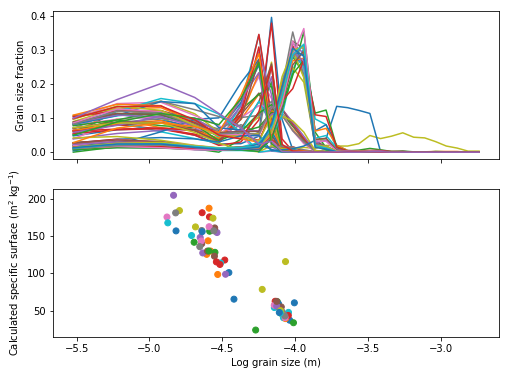

In [12]:
fig, axs = pl.subplots(2, 1, figsize=(8, 6), sharex=True)

# plot grain size distributions:
lines = []
for row in df.iterrows():
    l = axs[0].plot(np.log10(gs_bin_mean*1e-6), row[1][grain_size_ind1:grain_size_ind2].values.astype(float) / 100.0)
    lines.append(l)
    
colors = [l[-1].get_color() for l in lines]

axs[1].scatter(df['log10_grainsize_mean'], df['specific_surface_granular_fraction'], c=colors)


axs[1].set_xlabel('Log grain size (m)')

axs[0].set_ylabel('Grain size fraction')
axs[1].set_ylabel('Calculated specific surface (m$^2$ kg$^{-1}$)')

fn1 = os.path.split(filename)[-1][:-4]
fn2 = fn1 + '_grain_sizes_and_spec_surfaces.png'
fig_fn = os.path.join('figs', fn2)
print('saving figure as ', fig_fn)
fig.savefig(fig_fn)

#axs[0].set_xlabel('Log grain size (m)')

**Fig. caption** *Top panel: grain size distributions, bottom panel: calculated specific surface vs mean grain size*